ImagingReso for plotting ideal neutron resonance

In [15]:
import _plot_functions
import _functions
import numpy as np
import pandas as pd
import pprint
from periodictable.constants import avogadro_number

* Input sample info:
  1. Database selection. Only ENDF_VIII is surpported currently. 
  2. Elements you want plot as in string. Input takes chemical symbol in the form of
     'Co' as single element,  
     'AgCo' as Ag and Co foils stacked,
     UO3' as chemical compound. Chemical compound is only supported when compound_boo is 'Y', and input mixture density 
  3. Sample thickness in mm.
  4. Energy range (min, max) you would like it be plotted. Plotting in lamda is also supported.

In [16]:
'''Describe your sample: '''
# Input sample name or names as str, case sensitive
_input_formula = 'AgCo'  # input('Please input the chemicals? ')
_input_thick_mm = 0.025  # float(input('Please input the thickness or majority thickness of stacked foils in mm : '))
_input_thick_cm = _input_thick_mm/10
_database = 'ENDF_VIII'
energy_max = 300  # max incident energy in eV
energy_min = 0  # min incident energy in eV
energy_sub = 100  # steps used to interpolate database
sub_x = energy_sub * (energy_max - energy_min)  # steps used to interpolate database
compound_boo = 'N'  # Compound or single/multi elements foil/stacked foils: Y/N?

* How you would like the plot to be presented?

In [17]:
'''How you want the data to be plotted?'''
_plot_or_not = 'Y'
_energy_x_axis = 'Y'  # 1 means plot x-axis as energy in eV
_trans_y_axis = 'N'  # 1 means plot y-axis as transmission
_plot_each_ele_contribution = 'Y'  # 1 means plot each element's contribution
_plot_each_iso_contribution = 'N'  # 1 means plot each isotope's contribution
_plot_mixed = 'Y'  # 1 means plot mixed resonance

'''Export to clipboard for Excel or DataGraph?'''
_export_to_clipboard_boo = 'N'

* Parse input formula str

In [18]:
''' Parse input formula str and return:
(1) elements list, elemental ratio list
(2) isotopes dict in the form of {element1: [iso11, iso12, iso13, ...], 
                                  element2: [iso21, iso22, iso23, ...], 
                                  element3: [iso31, iso32, iso33, ...], 
                                  ...}
(3) isotopic ratio dict in the form of {element1: {iso11: iso_ratio11, iso12: iso_ratio12, iso13: iso_ratio13, ...},
                                        element2: {iso21: iso_ratio21, iso22: iso_ratio12, iso23: iso_ratio23, ...},
                                        element3: {iso31: iso_ratio31, iso32: iso_ratio12, iso33: iso_ratio33, ...},
                                        ...}
'''
formula_dict = _functions.input2formula(_input_formula)
elements = _functions.dict_key_list(formula_dict)
ratios = _functions.dict_value_list(formula_dict)
sum_ratios = sum(ratios)
isotope_dict = _functions.get_isotope_dicts(_database, elements)

Parsed chemical formula: {'Ag': 1, 'Co': 1}


* Generate dictionaries contain modified or unmodified thickness, mass of isotopes, mass of elements, atomic ratio of isotopes for each element, density.

In [19]:
# DICT 1: Thickness dict with option for modification
thick_cm_dict = _functions.repeat_value_dict(elements, _input_thick_cm)

# DICT 2: Isotopic mass dict
iso_mass_dicts = _functions.get_iso_mass_dicts_quick(elements, isotope_dict)

# Dict 3: Molar mass dict
molar_mass_dict = _functions.get_molar_mass_dict(elements)

# DICT 4: Isotope at.% dict with option for modification
iso_ratio_dicts = _functions.get_iso_ratio_dicts_quick(elements, isotope_dict)

# DICT 5: Density dict
density_gcm3_dict = _functions.get_density_dict(elements)

* The following part is only needed if there are parameters changed with input such as individual thickness or density for stacked foils. Atomic ratios of isotopes can also be modified in this step if they are differ from natural abundance.

In [20]:
# Update DICT 1: isotopic ratio changes lead to |Density| & |Molar mass| changes
# Thickness input:
special_thick_boo = 'N'
special_thick_element_str = str
special_thick_mm_list = []
special_thick_cm_list = np.array(special_thick_mm_list)/10
if compound_boo == 'N':
    if special_thick_boo == 'Y':
        thick_cm_dict = _plot_functions.modify_thick_cm_dict_by_input(thick_cm_dict, special_thick_element_str, special_thick_cm_list)

        
# Update DICT 3 & 4 & 5: isotopic ratio changes lead to |Density| & |Molar mass| changes
# Enriched isotope ratio input:
enrichment_boo = 'N'  # Isotopic enriched or depleted: Y/N?
enriched_element_str = 'U'
input_ratio_dict = {'U': [0., 0., .15, .85]}
                    # 'O': [1., 0., 0.]}  #{'233-U': 0., '234-U': 0., '235-U': 0.15, '238-U': 0.85}}
if enrichment_boo == 'Y':
    # Update isotope at.% ratio dict
    iso_ratio_dicts, enriched_element = _plot_functions.modify_iso_ratio_dicts(elements, isotope_dict, enriched_element_str, input_ratio_dict)
    # Update molar mass dict
    molar_mass_dict = _plot_functions.modify_molar_mass_dict_by_enrichment(molar_mass_dict, enriched_element, isotope_dict, iso_ratio_dicts, iso_mass_dicts)
    # Update density dict
    density_gcm3_dict = _plot_functions.modify_density_dict_by_enrichment(density_gcm3_dict, enriched_element, isotope_dict, iso_ratio_dicts)

    
# Update DICT 5: Density dict, if special case encountered
# Special density input:
special_density_boo = 'N'
special_density_element_str = str
special_density_gcm3_list = []
if compound_boo == 'N':
    if special_density_boo == 'Y':
        # Stacked foils and would like to modify density for specific element
        density_gcm3_dict = _plot_functions.modify_density_dict_by_input(density_gcm3_dict, special_density_element_str, special_density_gcm3_list)
else:
    if special_density_boo == 'Y':
        # Not isolated elements or mixture or compound need density input currently
        input_tot_density = 0.7875


*Updated DICT 6 for stoichimetric ratios

* Check parameter dictionaries with print()

In [22]:
print('Thickness (cm): ', thick_cm_dict)
print('Density (g/cm^3): ', density_gcm3_dict)
print('Molar weight (g/mol): ', molar_mass_dict)
print('Isotopic ratio (at.%): ', iso_ratio_dicts)

Thickness (cm):  {'Ag': 0.0025, 'Co': 0.0025}
Density (g/cm^3):  {'Ag': 10.5, 'Co': 8.9}
Molar weight (g/mol):  {'Ag': 107.8682, 'Co': 58.9332}
Stoichimetric ratio (at.%):  {'Ag': 0.39193601106969644, 'Co': 0.6080639889303036}
Isotopic ratio (at.%):  {'Ag': {'107-Ag': 0.51839, '109-Ag': 0.48161000000000004}, 'Co': {'58-Co': 0.0, '59-Co': 1.0}}


* Extract database and calulate neutron transmission or attenuation
Equations: 
1. N(atoms_per_cm3) 
        = density / {sum[ele.at% * sum(mass * iso.at%)} 
           = density / mass_sum
2. Transmission(ideal) 
        = exp{-l * N * {sum[ele.at% * sum(sigma * iso.at%)}} 
           = exp{-l * N * sigma_sum)


'''For plotting the database'''

In [23]:
'''Get (sigma * isotopic ratio) terms'''
sigma_iso_eleisodict = {}  # For transmission calculation at isotope level
sigma_iso_sum_eledict = {}  # For transmission calculation at element level
df_raw_dict = {}  # Raw sigma data for elements and isotopes
ele_at_ratio = 1
for el in elements:
    iso_ratio_list = list(dict.values(iso_ratio_dicts[el]))
    # Get sigma related terms
    file_names = _functions.get_file_path(_database, el)
    x_energy, sigma_iso_dict, sigma_iso_sum, df_raw_dict[el] \
        = _plot_functions.get_sigma_iso_terms_from_database(iso_ratio_dicts[el],
                                                            file_names,
                                                            energy_min,
                                                            energy_max,
                                                            iso_ratio_list,
                                                            sub_x)
    # Two level dict of isotopic array of (sigma * iso_ratio)
    sigma_iso_eleisodict[el] = sigma_iso_dict
    # One level dict of elemental array of (sigma * iso_ratio)
    sigma_iso_sum_eledict[el] = sigma_iso_sum
    print(isotope_dict[el])


['107-Ag', '109-Ag']
['58-Co', '59-Co']


In [24]:
'''Get atoms_per_cm^3 for each elements'''
if compound_boo == 'Y':
    # For compound
    compound_density = input_tot_density
    molar_mass_list = list(dict.values(molar_mass_dict))
    molar_mass_array = np.array(molar_mass_list)
    molar_mass_times_ratio_array = molar_mass_array * ratios
    molar_mass_times_ratio_sum = sum(molar_mass_times_ratio_array)
    atoms_per_cm3_dict = {}
    density_within_compound = {}
    for ele in elements:
        density_within_compound[ele] = compound_density * (formula_dict[ele] * molar_mass_dict[ele] / molar_mass_times_ratio_sum)
        atoms_per_cm3_dict[ele] = avogadro_number * density_within_compound[ele] / molar_mass_dict[ele]
    print('Number of atoms per cm^3 : ', atoms_per_cm3_dict)
else:
    # Stacked foils or single foil
    atoms_per_cm3_dict = {}
    for ele in elements:
        atoms_per_cm3_dict[ele] = avogadro_number * density_gcm3_dict[ele]/molar_mass_dict[ele]
    print('Number of atoms per cm^3 : ', atoms_per_cm3_dict)

Number of atoms per cm^3 :  {'Ag': 5.86201390168743e+22, 'Co': 9.094544659207374e+22}


* Create dictionary contains transmission or attenuation at elemental level and isotopic level in case of plotting elemental or isotopic contributions in total resonance.

In [25]:
""" Get resonance y-axis dictionaries:"""
y_ele_dict = {}
y_all_dict = {}
y_sum = 1.
if _trans_y_axis == 'Y':
    # Get transmission y dictionaries
    trans_iso_dict = {}
    trans_ele_dict = {}
    for ele in elements:
        y_iso_dict = {}
        for iso in isotope_dict[ele]:
            sigma_iso_isodict = sigma_iso_eleisodict[ele]
            trans_iso_dict[iso] = _functions.sig2trans_quick(thick_cm_dict[ele], atoms_per_cm3_dict[ele], sigma_iso_isodict[iso])
            y_iso_dict[iso] = trans_iso_dict[iso]
        trans_ele_dict[ele] = _functions.sig2trans_quick(thick_cm_dict[ele], atoms_per_cm3_dict[ele], sigma_iso_sum_eledict[ele])
        y_ele_dict[ele] = trans_ele_dict[ele]
        y_all_dict[ele] = y_iso_dict
        y_sum = y_sum * y_ele_dict[ele]
else:
    # Get attenuation y dictionaries
    trans_iso_dict = {}
    trans_ele_dict = {}
    for ele in elements:
        y_iso_dict = {}
        for iso in isotope_dict[ele]:
            sigma_iso_isodict = sigma_iso_eleisodict[ele]
            trans_iso_dict[iso] = _functions.sig2trans_quick(thick_cm_dict[ele], atoms_per_cm3_dict[ele], sigma_iso_isodict[iso])
            # Convert transmission to attenuation
            y_iso_dict[iso] = 1 - trans_iso_dict[iso]
        trans_ele_dict[ele] = _functions.sig2trans_quick(thick_cm_dict[ele], atoms_per_cm3_dict[ele], sigma_iso_sum_eledict[ele])
        # Convert transmission to attenuation
        y_ele_dict[ele] = 1 - trans_ele_dict[ele]
        y_all_dict[ele] = y_iso_dict
        y_sum = y_sum * trans_ele_dict[ele]
    # Convert transmission to attenuation
    y_sum = 1 - y_sum

print(y_sum)
print(y_ele_dict)
print(y_all_dict)

[ 0.59378716  0.02978077  0.02177412 ...,  0.00315092  0.00315613
  0.00316133]
{'Ag': array([ 0.37232554,  0.01526398,  0.01105388, ...,  0.00068347,
        0.00068885,  0.00069423]), 'Co': array([ 0.35282879,  0.01474181,  0.01084007, ...,  0.00246914,
        0.00246898,  0.00246882])}
{'Ag': {'107-Ag': array([ 0.1369645 ,  0.00510815,  0.00377282, ...,  0.00031254,
        0.00031247,  0.00031241]), '109-Ag': array([ 0.27271305,  0.01020798,  0.00730863, ...,  0.00037104,
        0.00037649,  0.00038194])}, 'Co': {'58-Co': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), '59-Co': array([ 0.35282879,  0.01474181,  0.01084007, ...,  0.00246914,
        0.00246898,  0.00246882])}}


* Plot the ideal resonance data:
  x_energy, y_trans_tot
* Or plot the trans dictionaries for elemental or isotopic transmissions 

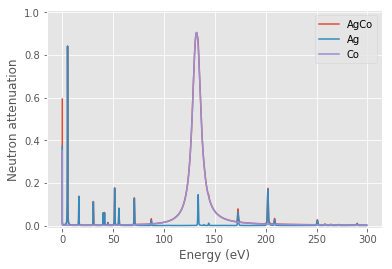

In [26]:
"""Plot the theoretical neutron resonance"""
if _plot_or_not == 'Y':
    _plot_functions.plot_resonance(_energy_x_axis,
                                  _trans_y_axis,
                                  _plot_mixed,
                                  _plot_each_ele_contribution,
                                  _plot_each_iso_contribution,
                                  elements,
                                  isotope_dict,
                                  x_energy,
                                  y_sum,
                                  y_ele_dict,
                                  y_all_dict,
                                  _input_formula)

* Option for exporting to clipboard for copy-paste into Excel or others to play with thickness and density values

In [27]:
# Export to clipboard for density and thickness manipulations with Excel or DataGraph
if _export_to_clipboard_boo == 'Y':
    _name = _input_formula
    df_yi_tot = pd.DataFrame(data=x_energy, index=None)
    df_yi_tot.rename(columns={0: 'eV' + _name}, inplace=True)
    df_yi_tot['lamda-' + _name] = _functions.ev2lamda(x_energy)
    df_yi_tot['sample_density-' + _name] = sample_density
    df_yi_tot['avo_divided-' + _name] = avo_divi_mass_iso_ele_sum
    df_yi_tot['sigma-' + _name] = yi_values_sum

    for ele in elements:
        _ele_str = str(ele)
        df_yi_tot['sigma-' + _ele_str] = sigma_iso_ele_sum_eledict[ele]
        df_test = pd.DataFrame(sigma_iso_ele_eleisodict[ele])
        df_yi_tot = pd.concat([df_yi_tot, df_test], axis=1)
    print(df_yi_tot.head())
    # Export to clipboard
    df_yi_tot.to_clipboard(excel=True)